<a href="https://colab.research.google.com/github/fikadawiyah/Renewable-Power-Generation-LSTM/blob/main/RENEWABLE_POWER_GENERATION_AND_WEATHER_CONDITIONS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

From Time:  2017-01-01 00:00:00
To Time  :  2021-05-13 21:00:00


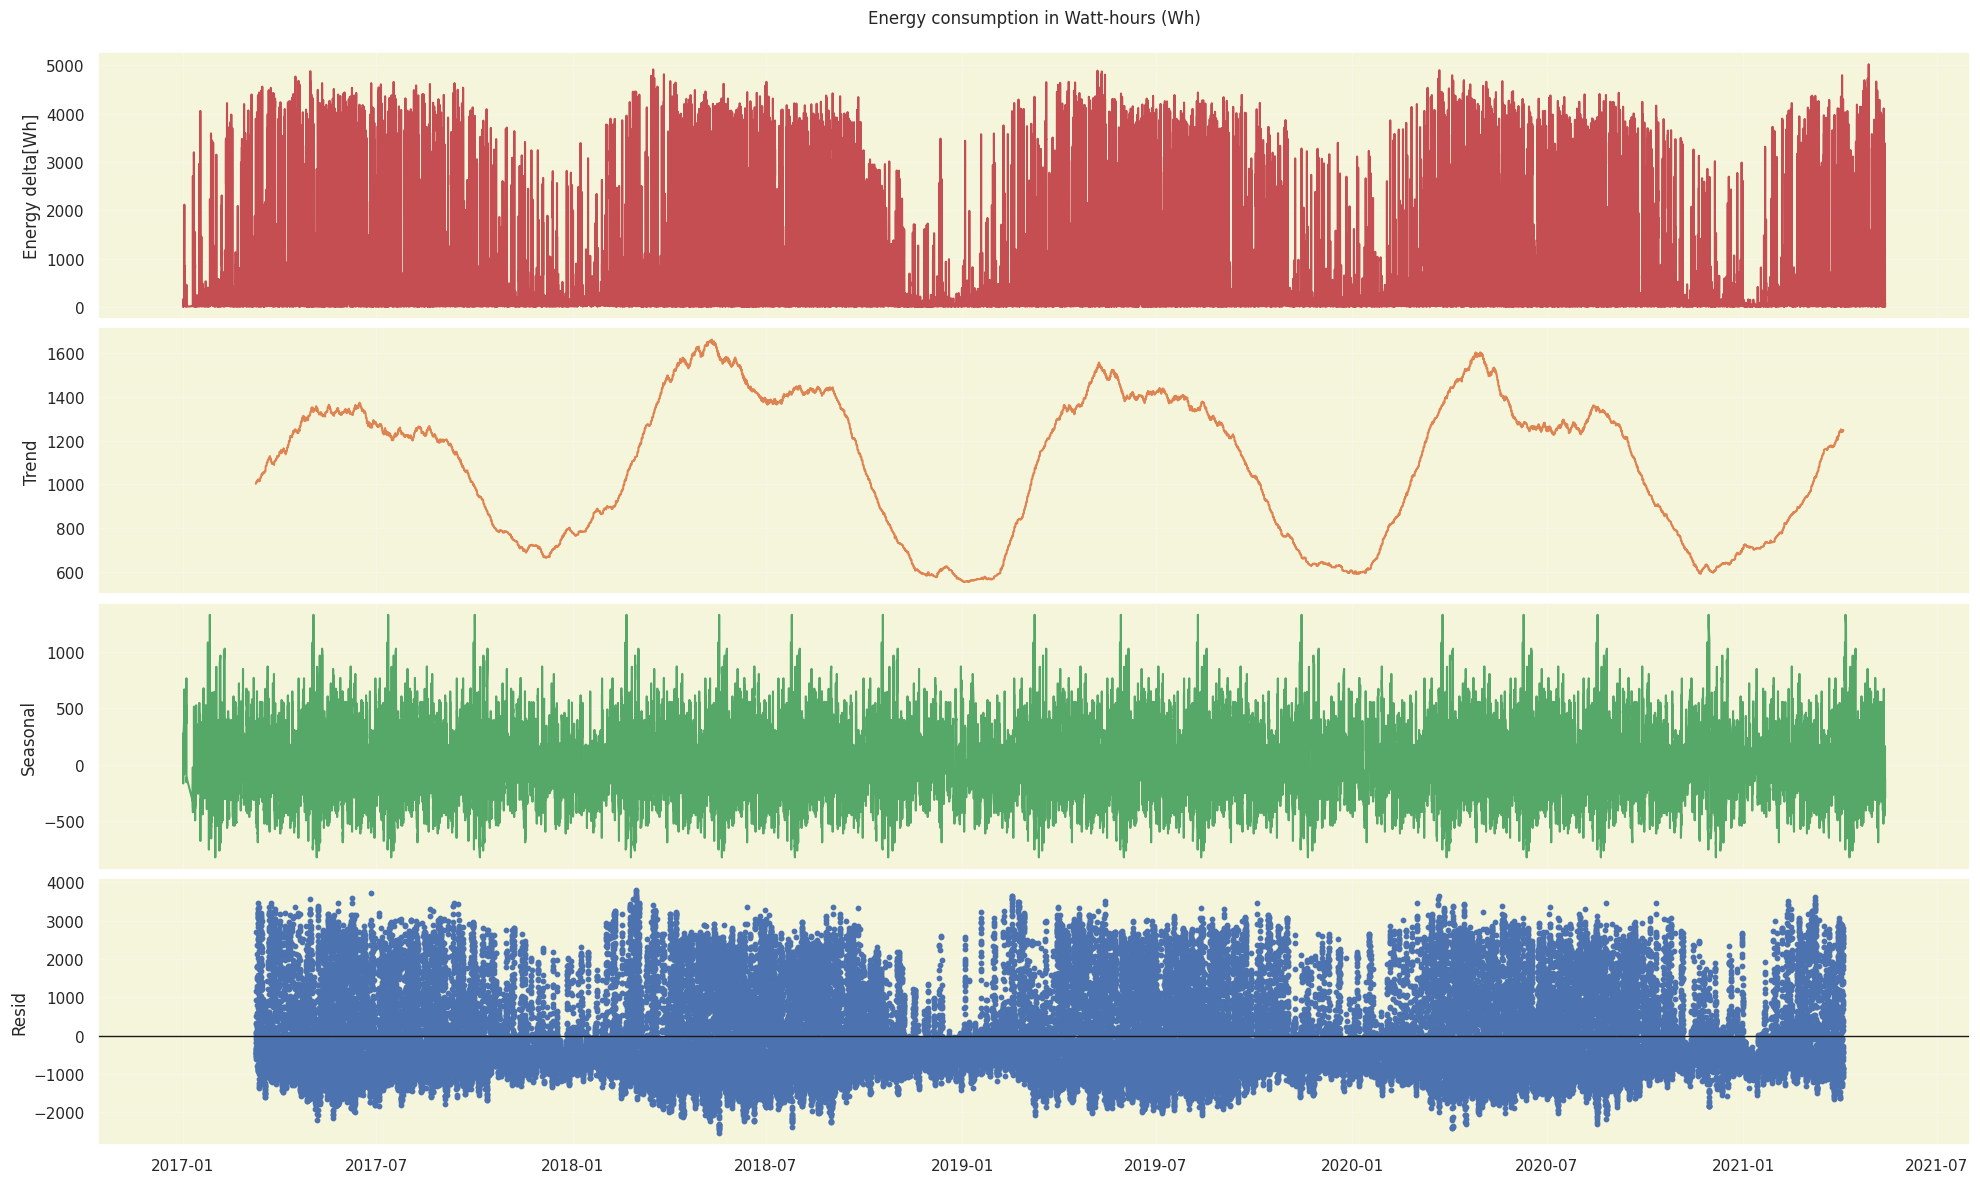

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/250
2182/2182 ━━━━━━━━━━━━━━━━━━━━ 96s 42ms/step - loss: 0.0117 - val_loss: 0.0091
Epoch 2/250
2182/2182 ━━━━━━━━━━━━━━━━━━━━ 92s 42ms/step - loss: 0.0075 - val_loss: 0.0092
Epoch 3/250
2182/2182 ━━━━━━━━━━━━━━━━━━━━ 90s 41ms/step - loss: 0.0073 - val_loss: 0.0097
Epoch 4/250
2182/2182 ━━━━━━━━━━━━━━━━━━━━ 142s 41ms/step - loss: 0.0072 - val_loss: 0.0095
454/454 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step


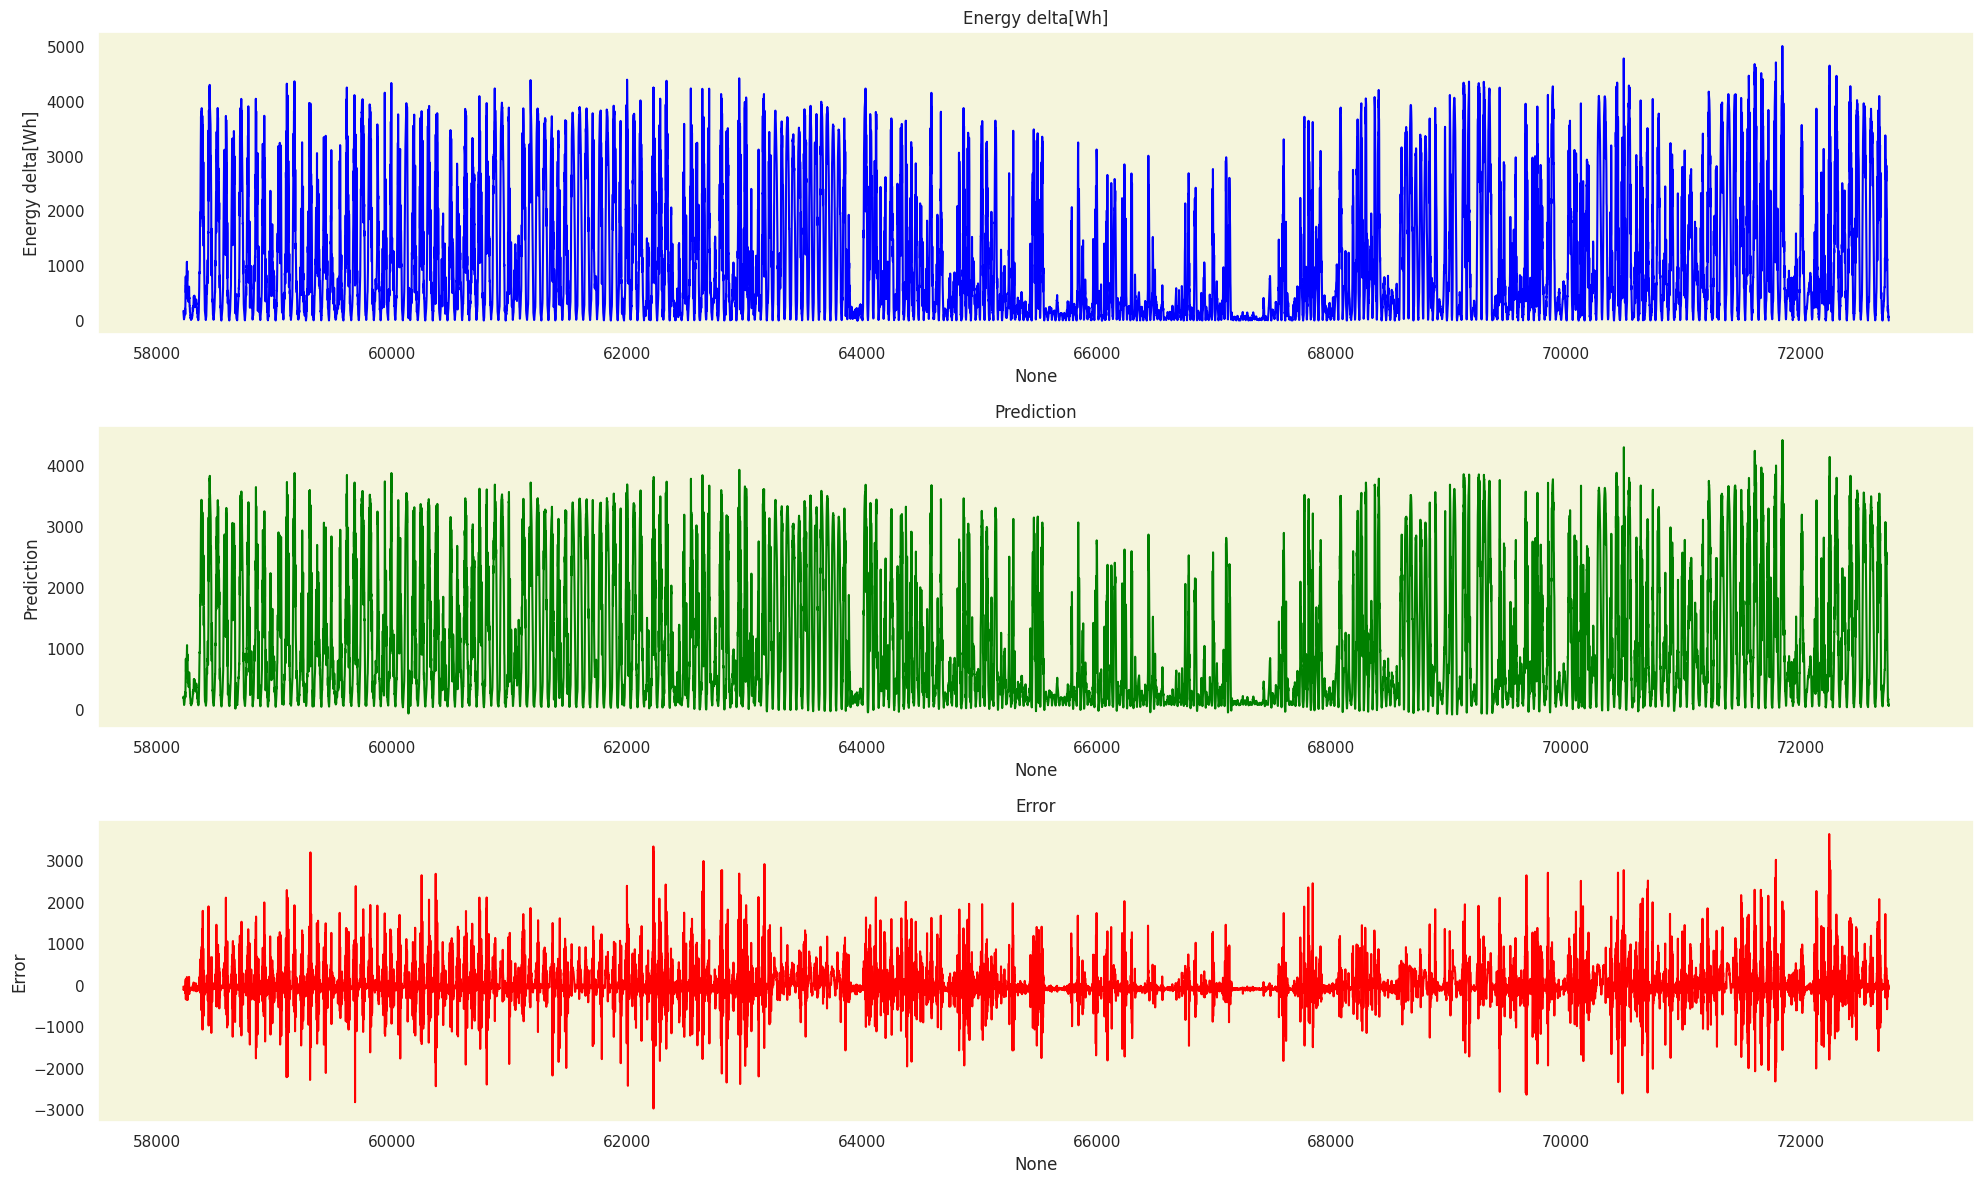

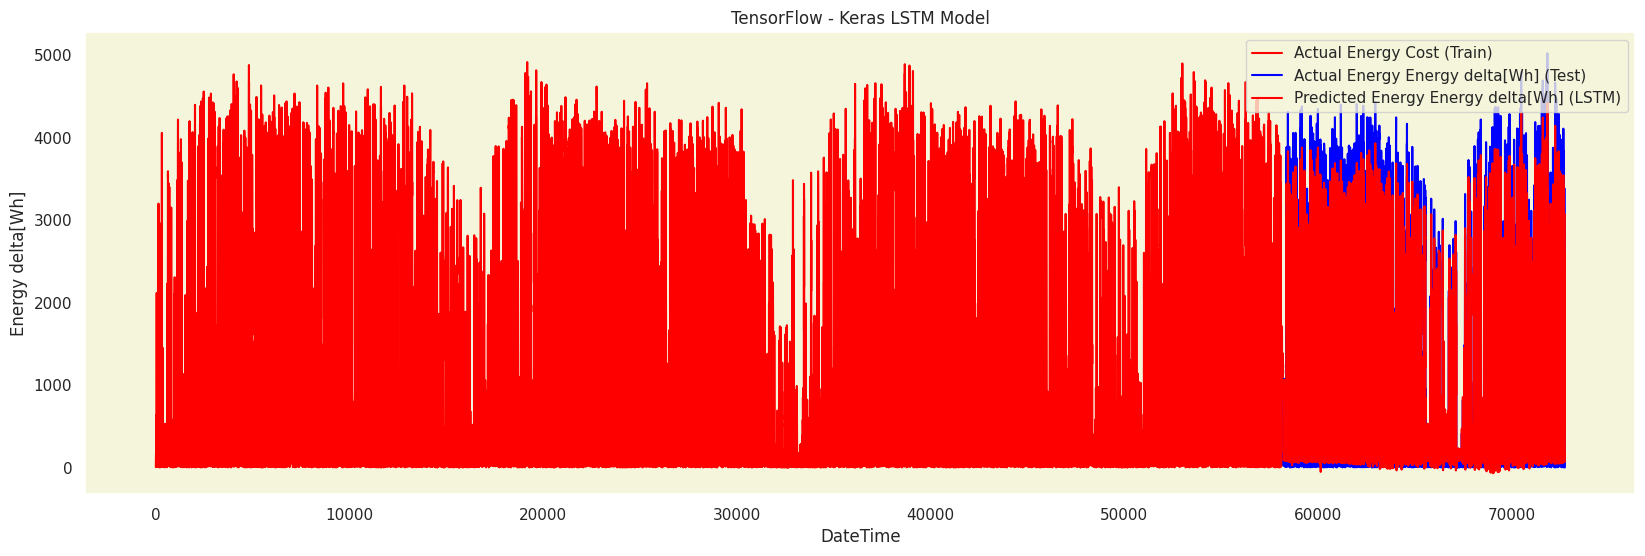

Explained Variance:
	 0.8633240604828895
MAE:
	 254.79741586878708
RMSE:
	 433.4375772507989


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.cm as cm
import matplotlib.dates as mdates
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import Sequential

# Set seaborn theme and plot settings
sns.set(rc={"axes.facecolor":"Beige", "axes.grid": False})
%matplotlib inline

# Load and preprocess the dataset
df = pd.read_csv("/content/Renewable.csv")

# Check date range
print("From Time: ", df['Time'].min())
print("To Time  : ", df['Time'].max())

# Convert 'Time' column to datetime
# Remove rows where 'Energy delta[Wh]' is zero
df['Time'] = pd.to_datetime(df['Time'])
df = df[df['Energy delta[Wh]'] != 0]
df1 = df[['Time', 'Energy delta[Wh]']].copy()
df1 = df1.set_index('Time')

# Define a function for seasonal decomposition plot
def seasonal_decompose_plotter(df: pd.DataFrame, period=12, title='', figsize=(20, 12)):
    decomposition = seasonal_decompose(df.values, period=period)
    de_season = decomposition.seasonal
    de_resid = decomposition.resid
    de_trend = decomposition.trend

    fig, ax = plt.subplots(4, sharex=True, figsize=figsize)

    ax[0].set_title(title)
    ax[0].plot(df.index, df.values, color='C3')
    ax[0].set_ylabel(df.keys()[0])
    ax[0].grid(alpha=0.25)

    ax[1].plot(df.index, de_trend, color='C1')
    ax[1].set_ylabel('Trend')
    ax[1].grid(alpha=0.25)

    ax[2].plot(df.index, de_season, color='C2')
    ax[2].set_ylabel('Seasonal')
    ax[2].grid(alpha=0.25)

    ax[3].axhline(y=0, color='k', linewidth=1)
    ax[3].scatter(df.index, de_resid, color='C0', s=10)
    ax[3].set_ylabel('Resid')
    ax[3].grid(alpha=0.25)

    plt.tight_layout(h_pad=0)
    plt.show()

    return decomposition

# Perform seasonal decomposition
_ = seasonal_decompose_plotter(df1, period=365*12, title='Energy consumption in Watt-hours (Wh)\n', figsize=(20, 12))

# Scaling the data
scaler = MinMaxScaler()
scaler_data = scaler.fit_transform(df1)

# Create DataFrame
index = np.arange(0, len(scaler_data), 1)
scaler_df = pd.DataFrame(scaler_data, index=index, columns=['Energy delta[Wh]'])

# Splitting the data
train_size = int(len(scaler_df) * 0.8)
train, test = scaler_df.iloc[:train_size], scaler_df.iloc[train_size:]

# Define a function to create dataset
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

# Define the time steps
n_steps = 24

# Prepare training and test data
X_train, y_train = create_dataset(train, train['Energy delta[Wh]'], n_steps)
X_test, y_test = create_dataset(test, test['Energy delta[Wh]'], n_steps)

# Build the LSTM model
lstm_model = keras.Sequential([
    LSTM(units=128, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True),
    Dropout(0.2),
    LSTM(units=64),
    Dropout(0.2),
    Dense(units=1)
])

# Compile the model
lstm_model.compile(
    loss='mean_squared_error',
    optimizer=keras.optimizers.Adam(0.001)
)

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_lstm_model.keras', monitor='val_loss', save_best_only=True)

# Train the model
history = lstm_model.fit(
    X_train, y_train,
    epochs=250,
    batch_size=24,
    validation_split=0.1,
    verbose=1,
    shuffle=False,
    callbacks=[early_stopping, model_checkpoint]
)

# Make predictions
lstm_pred = lstm_model.predict(X_test)
df_lstm_final = test[lstm_pred.shape[0]*-1:].copy()
df_lstm_final['Prediction'] = lstm_pred[:,0]

# Inverse transform the predictions and actual values
df_lstm_final['Energy delta[Wh]'] = scaler.inverse_transform(df_lstm_final['Energy delta[Wh]'].to_numpy().reshape(-1, 1))
df_lstm_final['Prediction'] = scaler.inverse_transform(df_lstm_final['Prediction'].to_numpy().reshape(-1, 1))

# Calculate the error
df_lstm_final['Error'] = df_lstm_final['Energy delta[Wh]'] - df_lstm_final['Prediction']

# Plot the results
fig, axes = plt.subplots(3, 1, figsize=(20, 12))
sns.lineplot(ax=axes[0], data=df_lstm_final, x=df_lstm_final.index, y='Energy delta[Wh]', color='Blue')
axes[0].set_title('Energy delta[Wh]')
sns.lineplot(ax=axes[1], data=df_lstm_final, x=df_lstm_final.index, y='Prediction', color='Green')
axes[1].set_title('Prediction')
sns.lineplot(ax=axes[2], data=df_lstm_final, x=df_lstm_final.index, y='Error', color='Red')
axes[2].set_title('Error')

plt.tight_layout()
plt.show()

# Function to report metrics
def report_metrics(y_true, y_pred):
    print("Explained Variance:\n\t", metrics.explained_variance_score(y_true, y_pred))
    print("MAE:\n\t", metrics.mean_absolute_error(y_true, y_pred))
    print("RMSE:\n\t", np.sqrt(metrics.mean_squared_error(y_true, y_pred)))

# Plot and report metrics
plt.figure(figsize=(20, 6))
plt.title('TensorFlow - Keras LSTM Model')
plt.plot(train.index, scaler.inverse_transform(train), color='red', label='Actual Energy Cost (Train)')
plt.xlabel('DateTime')
plt.ylabel('Energy delta[Wh]')
plt.plot(df_lstm_final.index, df_lstm_final['Energy delta[Wh]'], color='Blue', label='Actual Energy Energy delta[Wh] (Test)')
plt.plot(df_lstm_final.index, df_lstm_final['Prediction'], color='Red', label='Predicted Energy Energy delta[Wh] (LSTM)')
plt.legend()
plt.show()

# Report metrics
report_metrics(df_lstm_final['Energy delta[Wh]'].squeeze(), df_lstm_final['Prediction'].squeeze())